# Setup

In [1]:
import importlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from numpy.linalg import cond
from typing import List

# Matrixlib
from matrixlib import preconditioning as precon
from matrixlib.core import MatrixData, ValueProperties, BlockProperties

# Generate Synthetic Data
Generate a set of `n` square symmetrical and positive semi matrices of dimensions `MATRIX_DIM` to RAM.

## Define Constants
The following constants are used throughout the rest of the notebook.

In [2]:
MATRIX_DIM = 64
NUMBER_OF_MATRICES = 100
DIAGONAL_BAND_RADIUS = 10
RNG_SEED = 42

VALUE_COLORBAR = 'rocket'
BLOCK_COLORBAR = 'flare'

In [3]:
# Generate matrices
bgr_noise_value_props = ValueProperties(density_range=(0.3, 0.5), value_range=(0.0, 0.5))
noise_blk_value_props = ValueProperties(density_range=(0.3, 0.5), value_range=(0.3, 1.0))
noise_blk_block_props = BlockProperties(size_range=(3, 32), size_average=10, size_std_dev=0.66, gap_chance=0.5)
tdata_blk_value_props = ValueProperties(density_range=(0.5, 0.7), value_range=(0.3, 1.0))
tdata_blk_block_props = BlockProperties(size_range=(2, 32), size_average=10, size_std_dev=0.66, gap_chance=0.0)

test_data = MatrixData(
        dimension=MATRIX_DIM,
        band_radius=DIAGONAL_BAND_RADIUS,
        sample_size=NUMBER_OF_MATRICES,
        background_noise_value_properties=bgr_noise_value_props,
        block_noise_value_properties=noise_blk_value_props,
        block_noise_block_properties=noise_blk_block_props,
        block_data_value_properties=tdata_blk_value_props,
        block_data_block_properties=tdata_blk_block_props,
        seed=42,
        determinant_cutoff=0.01,
        print_debug=False
    )

In [4]:
labels = test_data.tdata_blk_starts
A_orig = test_data.matrices

# Verify Shape
print(f"Test Matrices Shape: {A_orig.shape}, Test Labels Shape: {labels.shape}")

Test Matrices Shape: (100, 64, 64), Test Labels Shape: (100, 64)


# Create Preconditioner from predicted block starts
### 1. Generate variants of the original matrix data as inversion targets (i.e. 'A' in 'Ax = b')

In [5]:
importlib.reload(precon)

A_flip = precon.prepare_matrix(A_orig, mapping_type='flip')
A_shift = precon.prepare_matrix(A_orig, mapping_type='shift')
A_minmax = precon.prepare_matrix(A_orig, mapping_type='minmax')

### 2. Invert Blocks (ensure non-singularity)

In [6]:
importlib.reload(precon)

precs = precon.generate_block_jacobi_preconditioner(sparse_matrices=A_orig, block_start_indicators=labels, apply_inverse_minmax_norm=True)

Block is singular, using pseudo-inverse for block    4 at indices 62:64
Block is singular, using pseudo-inverse for block   35 at indices 62:64
Block is singular, using pseudo-inverse for block   65 at indices 61:64
Block is singular, using pseudo-inverse for block   66 at indices 60:64
Block is singular, using pseudo-inverse for block   74 at indices 62:64
Block is singular, using pseudo-inverse for block   75 at indices 60:64
Block is singular, using pseudo-inverse for block   80 at indices 3:5
Block is singular, using pseudo-inverse for block   88 at indices 60:64


### 3. Analyze resulting data

In [7]:
# Check Condition Numbers
TARGET_INDEX = 0

# Select indices to analyze here 
ANALYTICS_TARGETS = [0, 1, 2, 3]

In [8]:

print(f"Analysing matrix at index [{TARGET_INDEX}]:")
print("-" * 80)
print("Condition number:")
print("-" * 80)
print(f"original: {cond(A_orig[TARGET_INDEX]):12.2f}")
print(f"flipped:  {cond(A_flip[TARGET_INDEX]):12.2f}")
print(f"shifted:  {cond(A_shift[TARGET_INDEX]):12.2f}")
print(f"minmax:   {cond(A_minmax[TARGET_INDEX]):12.2f}")
print(f"precon:   {cond(precs[TARGET_INDEX]):12.2f}")
print("-" * 80)
print("Condition number Product:")
print("-" * 80)
print(f"original: {cond(np.matmul(A_orig[TARGET_INDEX], precs[TARGET_INDEX])):12.2f}")
print(f"flipped:  {cond(np.matmul(A_flip[TARGET_INDEX], precs[TARGET_INDEX])):12.2f}")
print(f"shifted:  {cond(np.matmul(A_shift[TARGET_INDEX], precs[TARGET_INDEX])):12.2f}")
print(f"minmax:   {cond(np.matmul(A_minmax[TARGET_INDEX], precs[TARGET_INDEX])):12.2f}")
print("-" * 80)
print("Frobenius norm of difference between preconditioner and inverse:")
print("-" * 80)
print(f"original: {np.linalg.norm(precs[TARGET_INDEX] - np.linalg.inv(A_orig[TARGET_INDEX])):12.2f}")
print(f"flipped:  {np.linalg.norm(precs[TARGET_INDEX] - np.linalg.inv(A_flip[TARGET_INDEX])):12.2f}")
print(f"shifted:  {np.linalg.norm(precs[TARGET_INDEX] - np.linalg.inv(A_shift[TARGET_INDEX])):12.2f}")
print(f"minmax:   {np.linalg.norm(precs[TARGET_INDEX] - np.linalg.inv(A_minmax[TARGET_INDEX])):12.2f}")

Analysing matrix at index [0]:
--------------------------------------------------------------------------------
Condition number:
--------------------------------------------------------------------------------
original:      3626.69
flipped:        282.36
shifted:     128859.25
minmax:         425.78
precon:          31.48
--------------------------------------------------------------------------------
Condition number Product:
--------------------------------------------------------------------------------
original:     67178.91
flipped:       5346.10
shifted:    2506137.50
minmax:        8080.06
--------------------------------------------------------------------------------
Frobenius norm of difference between preconditioner and inverse:
--------------------------------------------------------------------------------
original:       318.74
flipped:         44.23
shifted:       2489.01
minmax:          52.54


In [9]:
print(f"Shape of matrix data:           {A_orig.shape}")
print(f"Shape of preconditioner data:   {precs.shape}")

for i in range(min(len(ANALYTICS_TARGETS), NUMBER_OF_MATRICES)):
    print("-" * 80)
    print(f"Condition number of matrix {ANALYTICS_TARGETS[i]:4d} (original):     {np.linalg.cond(A_orig[ANALYTICS_TARGETS[i]]):12.2f}")
    print(f"Condition number of matrix {ANALYTICS_TARGETS[i]:4d} (flipped):      {np.linalg.cond(A_flip[ANALYTICS_TARGETS[i]]):12.2f}")
    print(f"Condition number of matrix {ANALYTICS_TARGETS[i]:4d} (shifted):      {np.linalg.cond(A_shift[ANALYTICS_TARGETS[i]]):12.2f}")
    print(f"Condition number of matrix {ANALYTICS_TARGETS[i]:4d} (minmax):       {np.linalg.cond(A_minmax[ANALYTICS_TARGETS[i]]):12.2f}")
    print(f"Condition number of matrix {ANALYTICS_TARGETS[i]:4d} preconditioner: {np.linalg.cond(precs[ANALYTICS_TARGETS[i]]):12.2f}")


Shape of matrix data:           (100, 64, 64)
Shape of preconditioner data:   (100, 64, 64)
--------------------------------------------------------------------------------
Condition number of matrix    0 (original):          3626.69
Condition number of matrix    0 (flipped):            282.36
Condition number of matrix    0 (shifted):         128859.25
Condition number of matrix    0 (minmax):             425.78
Condition number of matrix    0 preconditioner:        31.48
--------------------------------------------------------------------------------
Condition number of matrix    1 (original):           314.81
Condition number of matrix    1 (flipped):            323.26
Condition number of matrix    1 (shifted):           9097.94
Condition number of matrix    1 (minmax):             233.43
Condition number of matrix    1 preconditioner:        83.03
--------------------------------------------------------------------------------
Condition number of matrix    2 (original):           1

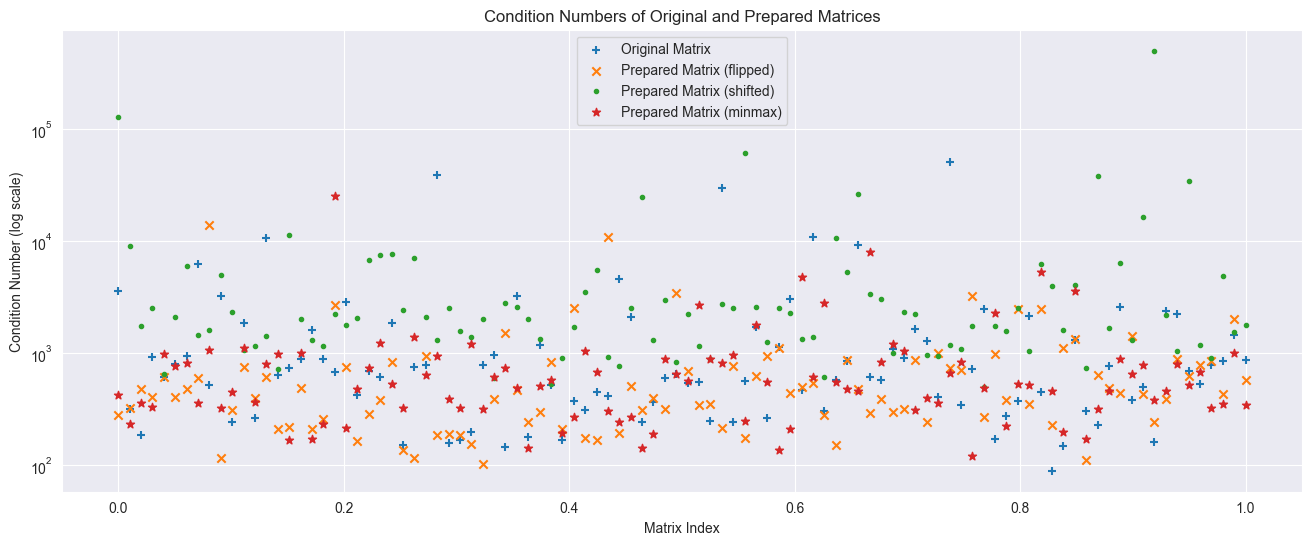

In [10]:
# generate x axis vector
x_vals = np.linspace(0, 1, num=NUMBER_OF_MATRICES)

# plot condition numbers 
plt.figure(figsize=(16, 6))
plt.scatter(x_vals, [np.linalg.cond(A_orig[i]) for i in range(A_orig.shape[0])], label='Original Matrix', marker='+')
plt.scatter(x_vals, [np.linalg.cond(A_flip[i]) for i in range(A_flip.shape[0])], label='Prepared Matrix (flipped)', marker='x')
plt.scatter(x_vals, [np.linalg.cond(A_shift[i]) for i in range(A_shift.shape[0])], label='Prepared Matrix (shifted)', marker='.')
plt.scatter(x_vals, [np.linalg.cond(A_minmax[i]) for i in range(A_minmax.shape[0])], label='Prepared Matrix (minmax)', marker='*')
plt.xlabel('Matrix Index')
plt.ylabel('Condition Number (log scale)')
plt.gca().set_yscale('log')
plt.title('Condition Numbers of Original and Prepared Matrices')
plt.legend()
plt.show()

# Run GMRES Solver with and without Preconditioner

In [11]:
importlib.reload(precon)

# Generate solution value vector
b = np.ones((NUMBER_OF_MATRICES, MATRIX_DIM))

In [12]:
print("Running GMRES for raw test matrices without preconditioner")
x_no_precon_orig, info_no_precon_orig, iters_no_precon_orig, residuals_no_precon_orig = precon.solve_with_gmres_monitored(matrix=A_orig, b_vector=b)

Running GMRES for raw test matrices without preconditioner
(100, 64, 64)

Without preconditioner:
--------------------------------------------------------------------------------
  Converged: 88 out of 100
  Average iterations: 3980.00
--------------------------------------------------------------------------------
  iterations: [12800   589   617  3321  3025  6544  8593 12623  2201  7750   756  3160
   719 12800  2577   443  2090  5916  3944  3777 12800  1708   992  2036
  2890   611  1662  2150 12800   526   468   729  5587  8500   347 12800
   601  7476  4312   642  1365   825  2941  2356 12800   300   746  1611
  1502  2655  2676   509  1712 12800   757  2484  7535  1696  6171 12800
  2122 12800  1403   744  6040 12800  3415  4792  6695   306   513  2482
  1755 12800  1978  2878  8006   798   762  2275  3843   510   152   379
 12800  1542   849  3977  5046   933  3790   582 10291  6427  1843   508
  1978  2055  4551   457]


In [13]:
print("Running GMRES for prepared matrices (flipped) without preconditioner")
x_no_precon_flip, info_no_precon_flip, iters_no_precon_flip, residuals_no_precon_flip = precon.solve_with_gmres_monitored(
    matrix=A_flip, b_vector=b)

Running GMRES for prepared matrices (flipped) without preconditioner
(100, 64, 64)

Without preconditioner:
--------------------------------------------------------------------------------
  Converged: 95 out of 100
  Average iterations: 2550.53
--------------------------------------------------------------------------------
  iterations: [  943   482  1278   568  2086  1175   852   664 12800   170   604  4534
   436  2079   759   390  1066   496   540 12800  2292   580   941  1323
  1873   363   116  8428   658   888   307   392   313  6663 12800  3010
  1771  1158  4890   586 12501   464   795 12800   392  1177   559  2838
  1204 12800  1581  1227  6402   684  2789   747   862   192  4058  3428
  1377  1509  1015   283  1612  3308   101  3131   637   502  2617   550
  1960  1665  2183  4040   624  5456  1453   184   587  2884  1100  4117
  9060   334  1302  1028   820 10222  2933  1098   927  2714  3746  6528
  2239  1208  5217  1208]


In [39]:
print("Running GMRES for prepared matrices (shifted) without preconditioner")
x_no_precon_shift, info_no_precon_shift, iters_no_precon_shift, residuals_no_precon_shift = precon.solve_with_gmres_monitored(
    matrix=A_shift, b_vector=b)

Running GMRES for prepared matrices (shifted) without preconditioner
(100, 64, 64)

Without preconditioner:
--------------------------------------------------------------------------------
  Converged: 98 out of 100
  Average iterations: 1165.92
--------------------------------------------------------------------------------
  iterations: [12800  5662  1074  1697    99   511    39   386   295  6604   550   203
   266  1005    46  1431    66   293    78  1451   243   113    92  6966
   160  1186   304    60   365   441   471   627   296   118  3303   194
  2185   298   117   224   328   222   314   440   145    65  6068   281
   771   259   631   324   172   367   483  2458   545   239   932   699
   633   311    71  6946  1346   147   528  1500   121   764  1351   255
   165    55    65   119    98   698   520   677   208  1193   494   105
   390   205 12800   572   145   161  2023   180   233   352 10345   422
   234   783   832   483]


In [40]:
print("Running GMRES for prepared matrices (minmax) without preconditioner")
x_no_precon_minmax, info_no_precon_minmax, iters_no_precon_minmax, residuals_no_precon_minmax = precon.solve_with_gmres_monitored(
    matrix=A_minmax, b_vector=b)

Running GMRES for prepared matrices (minmax) without preconditioner
(100, 64, 64)

Without preconditioner:
--------------------------------------------------------------------------------
  Converged: 92 out of 100
  Average iterations: 3151.96
--------------------------------------------------------------------------------
  iterations: [  794   429  1234   751  2975  1751  1227  1670  4156   734  1148 12800
  1768  1714   700   607  2627   419   374 12800   464  4098   998  5003
  1652   734 12800   280  5779  2549  1290  1625   747  1979  1371   401
   358  2903  2231   397   943 10504  8078   622   694   961   467   335
  4396  5030  3426  5522  1836  2415  9840   372  3544  1851   303   403
 12800  3608  1964  1221  1619   504 12800 12800  2478  3706   352   652
  1622  2323  2489   227  2099 11171   561  1578  5081  5380  3532   419
 12800   549   587  1583 12800  3009  6174  1233  2779  2550  4566   852
  2182  1387  9785  1495]


In [41]:
print("Running GMRES for raw test matrices with preconditioner base on test matrices")
x_precon_orig, info_precon_orig, iters_precon_orig, residuals_precon_orig = precon.solve_with_gmres_monitored(
    matrix=A_orig, b_vector=b, preconditioner=precs)

Running GMRES for raw test matrices with preconditioner base on test matrices
(100, 64, 64)

With preconditioner:
--------------------------------------------------------------------------------
  Converged: 82 out of 100
  Average iterations: 3824.40
--------------------------------------------------------------------------------
  iterations: [ 7775   418   479  1779  1659  2760  3199  5980 12800  3903   657  1215
   588 12800  1546   338  1380  3420  1986  9595  9733   893  3532  1063
  2015 12800   800  1735 12800   297   558   609  2151  6131   275 12800
 12800  2642 12800   640   798   760  1398  1109 12800   340   523   840
   855  1266  1318   540  1093 12800   573  1466  3504   634  2695  8418
   965 12800   997   637 12800 12800  1658  2378  3123   314   369  1439
  1035 12800  1112 12800  3708   532   390  1460  1819   471   199   260
 12800  1395   620  1640  2913   829  2052 12800 12800  2735  1251  2000
  1364  1077 12800  1417]


In [42]:
print("Running GMRES for prepared matrices (flipped) with preconditioner base on test matrices")
x_precon_flip, info_precon_flip, iters_precon_flip, residuals_precon_flip = precon.solve_with_gmres_monitored(
    matrix=A_flip, b_vector=b, preconditioner=precs)

Running GMRES for prepared matrices (flipped) with preconditioner base on test matrices
(100, 64, 64)

With preconditioner:
--------------------------------------------------------------------------------
  Converged: 90 out of 100
  Average iterations: 2492.48
--------------------------------------------------------------------------------
  iterations: [  826   380   766   475  1080   638   440   520 12800   164   618  2244
   449  2090   628   336   580   483   448 12800  1200   398   879  1190
   975  2560   126  3470   517   573   640   320   310  3044 12800  1439
 12800   915  2195   515  5616   418   560  6759   297   560   412  2227
   648  8877   938   632  2370 12800  1812   368  1453   234  1619  1443
   999  1960   844   306 12800  2037   114  1479   460   358  1317   359
  1259   980  1419 12800   637  3160  1053   197   413  1513  1018  2793
  4660   359   692   655 12800  6860  1657   555   646  2075  2075 12800
  1109   756  2800 12800]


In [43]:
print("Running GMRES for prepared matrices (shifted) with preconditioner base on test matrices")
x_precon_shift, info_precon_shift, iters_precon_shift, residuals_precon_shift = precon.solve_with_gmres_monitored(
    matrix=A_shift, b_vector=b, preconditioner=precs)

Running GMRES for prepared matrices (shifted) with preconditioner base on test matrices
(100, 64, 64)

With preconditioner:
--------------------------------------------------------------------------------
  Converged: 93 out of 100
  Average iterations: 1682.99
--------------------------------------------------------------------------------
  iterations: [ 5543  2692   671  1048   113   507    62   303 12786  3458   603   189
   280   725    62   817   305   293    88  1365   249   142   161  3543
   165 12786   276    83   312   456   371   635   303   152  2260   272
 12786   205 12785   406   223   246   252   300   198    93  4146   340
   456   242   595   259   164  1706   353  1101   286   252   523   605
   598  5246    85  3562   937   225   379   871   161   694   637   273
   170 12778    76 12789   114   451   308   482   233   603   495   128
   335   245  9385   392 12785   201  1145   166   260   305  5463   328
   238   421   958   779]


In [44]:
print("Running GMRES for prepared matrices (minmax) with preconditioner base on test matrices")
x_precon_minmax, info_precon_minmax, iters_precon_minmax, residuals_precon_minmax = precon.solve_with_gmres_monitored(
    matrix=A_minmax, b_vector=b, preconditioner=precs)

Running GMRES for prepared matrices (minmax) with preconditioner base on test matrices
(100, 64, 64)

With preconditioner:
--------------------------------------------------------------------------------
  Converged: 86 out of 100
  Average iterations: 3345.99
--------------------------------------------------------------------------------
  iterations: [  712   332   759   567  1987   975   906  1038 12800   516   719  5920
  1279  1520   594   417  2220   387   323 12800   410  2472   857  2726
   808 12800  8726   637  3480  1876   844  1246   654  1296   660   340
 12800  1114 12800   636   377 12800  3503   338   560   834   340   325
  1839  2509  2084  2393  1276  2640  4914   344  1840  1089   205   399
 12800 12800  1157   775 12800   820 12277  7458  1262  2660   334   489
  1234 12800  1639 12800  1426 12800   516  2111  2760  3087  2140   332
 11340   560   440   922 12800  1034  3063  2092  1220  1237  2960  2097
  1237  1000 12800  5958]


In [22]:
def print_residual_analytics(target_mat: np.ndarray, x_precon: np.ndarray, x_no_precon: np.ndarray, b_vec: np.ndarray, title: str) -> None:
    # precalculate some norms
    norm_b = [np.linalg.norm(b_vec[i]) for i in range(NUMBER_OF_MATRICES)]
    
    rel_residuals_precon = [np.linalg.norm(b[i] - target_mat[i] @ x_precon[i]) / norm_b[i] for i in range(NUMBER_OF_MATRICES)]
    rel_residuals_no_precon = [np.linalg.norm(b[i] - target_mat[i] @ x_no_precon[i]) / norm_b[i] for i in range(NUMBER_OF_MATRICES)]
    
    print(f"Relative residual for '{title}' matrices (min/max/mean):")
    print(f"  Without preconditioner:      "
          f"{np.min(rel_residuals_no_precon):.2e}          "
          f"{np.max(rel_residuals_no_precon):.2e}          "
          f"{np.mean(rel_residuals_no_precon):.2e}")
    print(f"  With preconditioner:         "
          f"{np.min(rel_residuals_precon):.2e}          "
          f"{np.max(rel_residuals_precon):.2e}          "
          f"{np.mean(rel_residuals_precon):.2e}")


print_residual_analytics(A_orig, x_precon_orig, x_no_precon_orig, b, "original")
print_residual_analytics(A_flip, x_precon_flip, x_no_precon_flip, b, "flipped")
print_residual_analytics(A_shift, x_precon_shift, x_no_precon_shift, b, "shifted")
print_residual_analytics(A_minmax, x_precon_minmax, x_no_precon_minmax, b, "minmax")


Relative residual for 'original' matrices (min/max/mean):
  Without preconditioner:      9.95e-04          3.59e-03          1.26e-03
  With preconditioner:         5.60e-04          1.21e-01          1.29e-02
Relative residual for 'flipped' matrices (min/max/mean):
  Without preconditioner:      9.92e-04          9.30e-03          1.83e-03
  With preconditioner:         8.01e-04          4.79e-03          1.33e-03
Relative residual for 'shifted' matrices (min/max/mean):
  Without preconditioner:      9.56e-04          1.18e-03          1.01e-03
  With preconditioner:         9.56e-04          1.18e-03          1.01e-03
Relative residual for 'minmax' matrices (min/max/mean):
  Without preconditioner:      9.94e-04          1.00e-03          9.98e-04
  With preconditioner:         9.54e-04          2.43e-02          3.31e-03


In [ ]:
# Calculate statistics for iteration counts
def iter_stats(iters):
    return {
        'min': np.min(iters),
        'max': np.max(iters),
        'mean': np.mean(iters),
        'median': np.median(iters)
    }

# Print statistics
print("Iteration count statistics without preconditioner:")
print("-" * 80)
print(f"Original: {iter_stats(iters_no_precon_orig)}")
print(f"Flipped:  {iter_stats(iters_no_precon_flip)}")
print(f"Shifted:  {iter_stats(iters_no_precon_shift)}")
print(f"Minmax:   {iter_stats(iters_no_precon_minmax)}")
print("-" * 80)
print("Iteration count statistics with preconditioner:")
print("-" * 80)
print(f"Original: {iter_stats(iters_precon_orig)}")
print(f"Flipped:  {iter_stats(iters_precon_flip)}")
print(f"Shifted:  {iter_stats(iters_precon_shift)}")
print(f"Minmax:   {iter_stats(iters_precon_minmax)}")
print("-" * 80)

# Define some arrays
result_data_list = [
    iters_no_precon_orig,
    iters_no_precon_flip,
    iters_no_precon_shift,
    iters_no_precon_minmax,
    iters_precon_orig,
    iters_precon_flip,
    iters_precon_shift,
    iters_precon_minmax,
]
result_data_labels_long = [
    'Original (no precon)',
    'Flipped (no precon)',
    'Shifted (no precon)',
    'Minmax (no precon)',
    'Original (with precon)',
    'Flipped (with precon)',
    'Shifted (with precon)',
    'Minmax (with precon)'
]
result_data_labels_stacked = [
    'Original\n(no precon)',
    'Flipped\n(no precon)',
    'Shifted\n(no precon)',
    'Minmax\n(no precon)',
    'Original\n(with precon)',
    'Flipped\n(with precon)',
    'Shifted\n(with precon)',
    'Minmax\n(with precon)'
]

# Create box plots
plt.figure(figsize=(10, 6))
bp = plt.boxplot(result_data_list, tick_labels=result_data_labels_stacked)

plt.title('GMRES Iteration Counts Comparison')
plt.ylabel('Number of Iterations')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add some jitter to the data points
for i, data in enumerate(result_data_list, 1):
    x = np.random.normal(i, 0.04, size=len(data))
    plt.plot(x, data, 'r.', alpha=0.2)

plt.tight_layout()
plt.show()

# Histogram
plt.figure(figsize=(8, 4))
plt.hist(result_data_list, label=result_data_labels_long, bins=20, alpha=0.7)
plt.xlabel('Number of Iterations')
plt.ylabel('Frequency')
plt.title('Distribution of GMRES Iteration Counts')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Function to plot matrices
def plot_matrices(matrices: List[np.ndarray], titles: List[str], colorbar: str = VALUE_COLORBAR) -> None:
    num_matrices = len(matrices)
    fig, axes = plt.subplots(1, num_matrices, figsize=(6 * num_matrices, 5))

    for i, (matrix, title) in enumerate(zip(matrices, titles)):
        ax = axes[i] if num_matrices > 1 else axes
        sns.heatmap(matrix, cmap=colorbar, ax=ax, cbar=True, square=True)
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()
    
# Plot matrices
for i in range(len(ANALYTICS_TARGETS)):
    index = ANALYTICS_TARGETS[i]
    plot_matrices(
        [A_orig[index], A_flip[index], A_shift[index], precs[index], np.matmul(A_flip[index], precs[index])], 
        ['Original Matrix', 'Flipped Matrix', 'Shifted Matrix', 'Preconditioner', 'Product'], 
        colorbar='coolwarm'
    )

End of notebook.